<a href="https://colab.research.google.com/github/mani2106/Competition-Notebooks/blob/master/Feature_Engineering_edelweiss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connecting and importing data

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!pip install -U graphviz pandas featuretools

In [0]:
import pandas as pd
import os
import featuretools as ft

path = 'gdrive/My Drive/Comp data'

In [0]:
cust_data =  pd.read_excel(os.path.join(path, 'Customers_31JAN2019.xlsx'))
em_data = pd.read_excel(os.path.join(path, 'RF_Final_Data.xlsx'))
lm_data = pd.read_excel(os.path.join(path, 'LMS_31JAN2019.xlsx'))

In [0]:
lm_data.dropna(subset = ['CUSTOMERID'], inplace=True)
lm_data.CUSTOMERID = lm_data.CUSTOMERID.astype('int64')

# Setting variable types to faciliate feature engineering

Mostly object __(string)__ type data can be inferred as categorical in featuretools.

In [0]:
# get lists of string columns across the datasets
cust_cat = cust_data.select_dtypes(include = ['object']).columns.tolist()

cust_cat.extend(['BRANCH_PINCODE', 'CUST_CONSTTYPE_ID', 'CUST_CATEGORYID'])

lm_cat = lm_data.select_dtypes(include = ['object']).columns.tolist()
lm_cat.extend(['MOB', 'SCHEMEID'])

em_cat = list(
    set(em_data.select_dtypes(include = ['object']).columns.tolist())
    -
    # excluding this because we may generate text features from this 
    # eg. count of words
    set(['Preprocessed_EmailBody', 'Preprocessed_Subject',
         'Preprocessed_EmailBody_proc'])
             )

In [0]:
# This column will be inderred as datetime index so need to make it a category
em_cat.remove('Date')

In [0]:
# Construct dictionaries with column names as keys and desired data type as values

cust_vtypes = dict.fromkeys(cust_cat, ft.variable_types.Categorical)

lm_vtypes = dict.fromkeys(lm_cat, ft.variable_types.Categorical)

em_vtypes = dict.fromkeys(em_cat, ft.variable_types.Categorical)

em_text_types = dict.fromkeys(['Preprocessed_EmailBody', 'Preprocessed_Subject',
         'Preprocessed_EmailBody_proc'], ft.variable_types.Text)

em_vtypes.update(em_text_types)

# Creating Entity Sets for feature engineering

In [0]:
es = ft.EntitySet()

# dropping empty columns inferred from our EDA
es = es.entity_from_dataframe(entity_id="customers",
                              dataframe=cust_data.drop(['PROFESSION',
                                                       'OCCUPATION'], axis=1),
                              index="CUSTOMERID",
                              variable_types=cust_vtypes)

In [0]:
es = es.entity_from_dataframe(entity_id="Email",
                              dataframe=em_data.drop(['Unnamed: 0'],axis=1),
                              index='TicketId',
                              time_index = "Date",
                              variable_types=em_vtypes)

In [0]:
es = es.entity_from_dataframe(entity_id="Loan transaction data",
                              dataframe=lm_data,
                              index='t_id',
                              make_index=True,
                              time_index = 'AUTHORIZATIONDATE',
                              variable_types=lm_vtypes)

In [0]:
cols_to_seperate = ['CITY','PRODUCT','NPA_IN_LAST_MONTH','NPA_IN_CURRENT_MONTH',
                    'MOB','SCHEMEID','CUSTOMERID']

es = es.normalize_entity(base_entity_id="Loan transaction data",
                         new_entity_id="Loan data",
                         index="AGREEMENTID",make_time_index= True,
                         additional_variables=cols_to_seperate)

In [0]:
es

Entityset: None
  Entities:
    customers [Rows: 10000, Columns: 13]
    Email [Rows: 7511, Columns: 14]
    Loan transaction data [Rows: 623734, Columns: 32]
    Loan data [Rows: 32895, Columns: 9]
  Relationships:
    Loan transaction data.AGREEMENTID -> Loan data.AGREEMENTID

# Adding relationships between entities

In [0]:
rel1 = ft.Relationship(
    es['customers']['CUSTOMERID'],es['Loan data']['CUSTOMERID']
)
rel2 = ft.Relationship(
    es['customers']['CUSTOMERID'], es['Email']['Masked_CustomerID']
)

In [0]:
es = es.add_relationships([rel1, rel2])

In [0]:
es

Entityset: None
  Entities:
    customers [Rows: 10000, Columns: 13]
    Email [Rows: 7511, Columns: 14]
    Loan transaction data [Rows: 623734, Columns: 32]
    Loan data [Rows: 32895, Columns: 9]
  Relationships:
    Loan transaction data.AGREEMENTID -> Loan data.AGREEMENTID
    Loan data.CUSTOMERID -> customers.CUSTOMERID
    Email.Masked_CustomerID -> customers.CUSTOMERID

# Relationship Plot

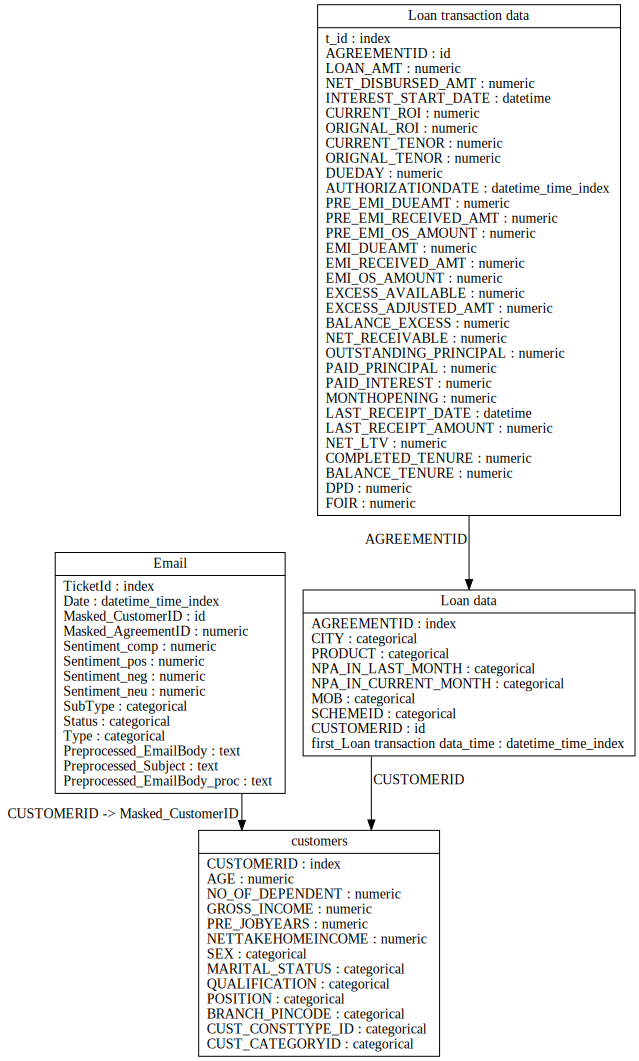

In [0]:
es.plot(to_file = os.path.join(path, "data.png"))

In [0]:
from featuretools.primitives import make_trans_primitive
from featuretools.variable_types import Numeric

# Create two new functions for our two new primitives since some variables
# have large numbers

def Log(column):
    return np.log(column)
def Square_Root(column):
    return np.sqrt(column)

# Create the primitives

log_prim = make_trans_primitive(
    function=Log, input_types=[Numeric], return_type=Numeric)

square_root_prim = make_trans_primitive(
    function=Square_Root, input_types=[Numeric], return_type=Numeric)

Quoting from competition description

Foreclosure means repaying the outstanding loan amount in a __single payment__ instead of with EMIs while balance transfer is transferring outstanding Loan availed from one Bank / Financial Institution to another Bank / Financial Institution, usually on the grounds of better service, top-up on the existing loan, proximity of branch, saving on interest repayments, etc.

__Assumptions__:
A customer's foreclosure intention can be predicted if 

1.   He/she has paid more EMI in the recent past
2.   The Tenor period has been reduced
3.   Excess amount received is high

In [0]:
ft.primitives.list_primitives()

In [0]:
# # Difference between current and pre received amount
# RECEIVED_LARGE = ft.Feature(es['Loan transaction data']['EMI_RECEIVED_AMT'] 
#                             - es['Loan transaction data']['PRE_EMI_RECEIVED_AMT'])

# # Difference between current and last received amount
# INCREASED_RECEIVED = ft.Feature(es['Loan transaction data']['EMI_RECEIVED_AMT'] 
#                                 - es['Loan transaction data']['LAST_RECEIPT_AMOUNT'])
# TENOR_IND = ft.Feature(es['Loan transaction data']['CURRENT_TENOR'] 
#                        - es['Loan transaction data']['ORIGNAL_TENOR'])

# Excess paid amount
EXCESS_LARGE = ft.Feature(es['Loan transaction data']['EXCESS_AVAILABLE']) > 1.53e4

# # Threshold for Recieved amounts
# RECEIVED_LARGE_TRUE = ft.Feature(RECEIVED_LARGE)>2e4
# INCREASED_RECEIVED_TRUE = ft.Feature(INCREASED_RECEIVED)>100


seed_features = [EXCESS_LARGE]

agg_primitives=[
        'std', 'mean', 'count'
]
trans_primitives=['num_words','num_characters']

trans_primitives.append(log_prim)
trans_primitives.append(square_root_prim)

ignore_variables = {
    "Loan data": "first_Loan transaction data_time"
}

# Feature Engineering

In [0]:
# Let's see what we can generate from the data and relationships we have
# agg_primitives = ["std", "skew", "mean","median", "count", 'mode'],
# trans_primitives = "num_words cum_mean days_since percentile num_characters".split(),

feature_defs = ft.dfs(entityset=es, target_entity="Loan data", max_depth=2,
                      agg_primitives = agg_primitives,
                      trans_primitives = trans_primitives,
                      seed_features = seed_features,
                      ignore_variables = ignore_variables,
                      features_only=True, verbose = True)

Built 12370 features


In [0]:
# Names of features
feature_defs

Lets __generate__ the features

In [0]:
feature_matrix, _ = ft.dfs(entityset=es, target_entity="Loan data",
                                    agg_primitives = agg_primitives,
                                    trans_primitives = trans_primitives,
                                    seed_features = seed_features,
                                    ignore_variables = ignore_variables,
                                    max_depth=1,features_only=False,
                                    verbose = True)

Built 158 features


Elapsed: 00:00 | Remaining: ? | Progress:   0%|          | Calculated: 0/11 chunks

Elapsed: 04:46 | Remaining: 47:45 | Progress:   9%|▉         | Calculated: 1/11 chunks

Elapsed: 09:10 | Remaining: 41:57 | Progress:  18%|█▊        | Calculated: 2/11 chunks

Elapsed: 13:35 | Remaining: 36:42 | Progress:  27%|██▋       | Calculated: 3/11 chunks

Elapsed: 17:58 | Remaining: 31:42 | Progress:  36%|███▋      | Calculated: 4/11 chunks

Elapsed: 22:24 | Remaining: 27:00 | Progress:  45%|████▌     | Calculated: 5/11 chunks

Elapsed: 26:52 | Remaining: 22:26 | Progress:  55%|█████▍    | Calculated: 6/11 chunks

Elapsed: 31:18 | Remaining: 17:53 | Progress:  64%|██████▎   | Calculated: 7/11 chunks

Elapsed: 35:44 | Remaining: 13:23 | Progress:  73%|███████▎  | Calculated: 8/11 chunks

Elapsed: 40:10 | Remaining: 08:54 | Progress:  82%|████████▏ | Calculated: 9/11 chunks

Elapsed: 44:26 | Remaining: 04:23 | Progress:  91%|█████████ | Calculated: 10/11 chunks

Elapsed: 44:27

# Persist feature matrix for Loan

In [0]:
feature_matrix.to_csv(os.path.join(path, 'feature_agg.csv'))

False